<a href="https://colab.research.google.com/github/divyanshuraj6815/eva/blob/master/Experiment%2014/DavidNet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time, math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#import tensorflow as tf
#import tensorflow.compat.v1.contrib.eager as tfe

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tf.enable_eager_execution()

In [3]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [4]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [5]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.drop = tf.keras.layers.Dropout(0.05)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.drop(self.conv(inputs))))

In [6]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [7]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [19]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.repeat (X_train[:, :, :, np.newaxis], [3], axis = 3)
x_test = np.repeat (X_test[:, :, :, np.newaxis], [3], axis = 3)
#x_train = x_train[:, :, :, np.newaxis]
#x_test = x_test[:, :, :, np.newaxis]
print (x_train.shape, y_train.shape)

len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))
print (train_mean)
print (train_std)

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)
print (x_train.shape, x_test.shape)

(60000, 28, 28, 3) (60000,)
[33.31842145 33.31842145 33.31842145]
[78.56749 78.56749 78.56749]
(60000, 36, 36, 3) (10000, 28, 28, 3)


In [9]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_tf_example (image, label):
  return tf.train.Example (features = tf.train.Features (feature = {'image' : _bytes_feature (image.tobytes ()), 'label' : _int64_feature (label)}))

In [10]:
def write_tf_records (x, y, file_path):
  writer = tf.io.TFRecordWriter (file_path)
  for i, x in enumerate (x_train):
    tf_example = create_tf_example (x, y[i])
    writer.write (tf_example.SerializeToString ())

In [11]:
#write_tf_records (x_train, y_train, 'cifar10.tfrecords')
write_tf_records (x_train, y_train, 'fmnist.tfrecords')

In [12]:
def decode (serialized_example):
  """
  Parses an image and label from the given `serialized_example`.
  It is used as a map function for `dataset.map`
  """
  IMAGE_SIZE = 36
  IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE * 3
  
  # 1. define a parser
  features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'image': tf.FixedLenFeature([], tf.string),
          'label': tf.FixedLenFeature([], tf.int64),
      })

  # 2. Convert the data
  image = tf.decode_raw(features['image'], tf.float32)
  image.set_shape((IMAGE_PIXELS))
  image = tf.cast (tf.reshape (image, [IMAGE_SIZE, IMAGE_SIZE, 3]), tf.float32)

  label = tf.cast(features['label'], tf.int64)

  # 3. reshape
  return image, label

In [13]:
def cutout (image, cutout_num):
  z = 28
  rand_x = np.random.randint (0, z + cutout_num)
  rand_y = np.random.randint (0, z + cutout_num)
  new_image = np.ones ([z + cutout_num, z + cutout_num, 3])
  new_image[rand_x : rand_x + cutout_num, rand_y : rand_y + cutout_num, :] = 0
  new_image = new_image[cutout_num : cutout_num + z, cutout_num : cutout_num + z, :]

  mean_value = tf.reduce_mean(image, axis=(0, 1, 2))
  mean_image = 1 - new_image
  mean_image = mean_image * mean_value

  mean_image = tf.convert_to_tensor (mean_image, dtype='float32')
  new_image = tf.convert_to_tensor (new_image, dtype='float32')
  image = image * new_image
  image = image + mean_image
  
  return image

In [14]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (cutout (tf.image.random_flip_left_right(tf.random_crop(x, [28, 28, 3])), 8), y)

In [15]:
#dataset = tf.data.TFRecordDataset ('cifar10.tfrecords')
dataset = tf.data.TFRecordDataset ('fmnist.tfrecords')
dataset = dataset.map (decode)

In [16]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
train_graph = {'epochs' : [], 'train_acc' : [], 'train_loss' : [], 'val_acc' : [], 'val_loss' : [], 'learning_rate' : [], 'time_taken' : []}

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(2)
  train_set = dataset.map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  train_graph['epochs'].append (epoch + 1)
  train_graph['train_loss'].append (train_loss / len_train)  
  train_graph['train_acc'].append (train_acc / len_train)  
  train_graph['val_loss'].append (test_loss / len_test)  
  train_graph['val_acc'].append (test_acc / len_test)  
  train_graph['learning_rate'].append (lr_schedule(epoch+1)) 
  train_graph['time_taken'].append (str (time.time() - t))

  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


0it [00:00, ?it/s]

epoch: 1 lr: 0.08 train loss: 0.8016987600326538 train acc: 0.7707333333333334 val loss: 0.13421591453552245 val acc: 0.9577 time: 84.42309403419495


0it [00:00, ?it/s]

epoch: 2 lr: 0.16 train loss: 0.17292970638275146 train acc: 0.9471166666666667 val loss: 0.09007727842330933 val acc: 0.9701 time: 123.23865175247192


0it [00:00, ?it/s]

epoch: 3 lr: 0.24 train loss: 0.12995559148788452 train acc: 0.9585 val loss: 0.0802537764787674 val acc: 0.9733 time: 161.85837769508362


0it [00:00, ?it/s]

epoch: 4 lr: 0.32 train loss: 0.05218664077123006 train acc: 0.9829166666666667 val loss: 0.13534461612701415 val acc: 0.9544 time: 200.36626410484314


0it [00:00, ?it/s]

epoch: 5 lr: 0.4 train loss: 0.06688549160957337 train acc: 0.9785333333333334 val loss: 0.051172595953941344 val acc: 0.9828 time: 239.19866847991943


0it [00:00, ?it/s]

epoch: 6 lr: 0.37894736842105264 train loss: 0.04204515739281972 train acc: 0.9864 val loss: 0.054915958261489865 val acc: 0.982 time: 278.9900312423706


0it [00:00, ?it/s]

epoch: 7 lr: 0.35789473684210527 train loss: 0.03737796035607656 train acc: 0.9879666666666667 val loss: 0.07387933044433594 val acc: 0.9761 time: 317.7671916484833


0it [00:00, ?it/s]

epoch: 8 lr: 0.33684210526315794 train loss: 0.1118331536769867 train acc: 0.9635666666666667 val loss: 0.03343869600594044 val acc: 0.9883 time: 356.3980360031128


0it [00:00, ?it/s]

epoch: 9 lr: 0.31578947368421056 train loss: 0.07655538367430369 train acc: 0.97485 val loss: 0.04359784572124481 val acc: 0.9851 time: 395.10446548461914


0it [00:00, ?it/s]

epoch: 10 lr: 0.2947368421052632 train loss: 0.030575878393650054 train acc: 0.9904333333333334 val loss: 0.026715142613649368 val acc: 0.9913 time: 435.0758981704712


0it [00:00, ?it/s]

epoch: 11 lr: 0.2736842105263158 train loss: 0.07756398480733236 train acc: 0.9746333333333334 val loss: 0.046276953822374345 val acc: 0.9856 time: 473.8105959892273


0it [00:00, ?it/s]

epoch: 12 lr: 0.25263157894736843 train loss: 0.028120797779162723 train acc: 0.9908833333333333 val loss: 0.03481019221842289 val acc: 0.9889 time: 512.3902337551117


0it [00:00, ?it/s]

epoch: 13 lr: 0.23157894736842108 train loss: 0.023835693176587423 train acc: 0.9923833333333333 val loss: 0.033649879348278046 val acc: 0.9892 time: 550.857613325119


0it [00:00, ?it/s]

epoch: 14 lr: 0.2105263157894737 train loss: 0.054893163275718686 train acc: 0.9819833333333333 val loss: 0.03462156123518944 val acc: 0.9888 time: 589.322420835495


0it [00:00, ?it/s]

epoch: 15 lr: 0.18947368421052635 train loss: 0.022308183685938517 train acc: 0.9927833333333334 val loss: 0.0254228399515152 val acc: 0.9915 time: 627.7451009750366


0it [00:00, ?it/s]

epoch: 16 lr: 0.16842105263157897 train loss: 0.0285618760317564 train acc: 0.99095 val loss: 0.02733205748796463 val acc: 0.991 time: 667.4295520782471


0it [00:00, ?it/s]

epoch: 17 lr: 0.1473684210526316 train loss: 0.05376339530944824 train acc: 0.9814 val loss: 0.03243144891262054 val acc: 0.9895 time: 705.7932562828064


0it [00:00, ?it/s]

epoch: 18 lr: 0.12631578947368421 train loss: 0.04345198683738709 train acc: 0.9854333333333334 val loss: 0.026549513694643975 val acc: 0.9917 time: 744.2081069946289


0it [00:00, ?it/s]

epoch: 19 lr: 0.10526315789473689 train loss: 0.05921718063354492 train acc: 0.9804666666666667 val loss: 0.02327148048132658 val acc: 0.9913 time: 782.8898088932037


0it [00:00, ?it/s]

epoch: 20 lr: 0.08421052631578951 train loss: 0.017866304909686246 train acc: 0.9944166666666666 val loss: 0.02221925811767578 val acc: 0.9927 time: 821.3262710571289


0it [00:00, ?it/s]

epoch: 21 lr: 0.06315789473684214 train loss: 0.029276823949813843 train acc: 0.9906166666666667 val loss: 0.020289605745673178 val acc: 0.993 time: 859.7498414516449


0it [00:00, ?it/s]

epoch: 22 lr: 0.04210526315789476 train loss: 0.016346320856610932 train acc: 0.9947 val loss: 0.022107559221982955 val acc: 0.9916 time: 898.4112486839294


0it [00:00, ?it/s]

epoch: 23 lr: 0.02105263157894738 train loss: 0.013763793023427328 train acc: 0.9957666666666667 val loss: 0.022637994116544723 val acc: 0.9919 time: 936.8511552810669


0it [00:00, ?it/s]

epoch: 24 lr: 0.0 train loss: 0.014354761689901352 train acc: 0.9953 val loss: 0.02179810557514429 val acc: 0.9923 time: 975.1703407764435


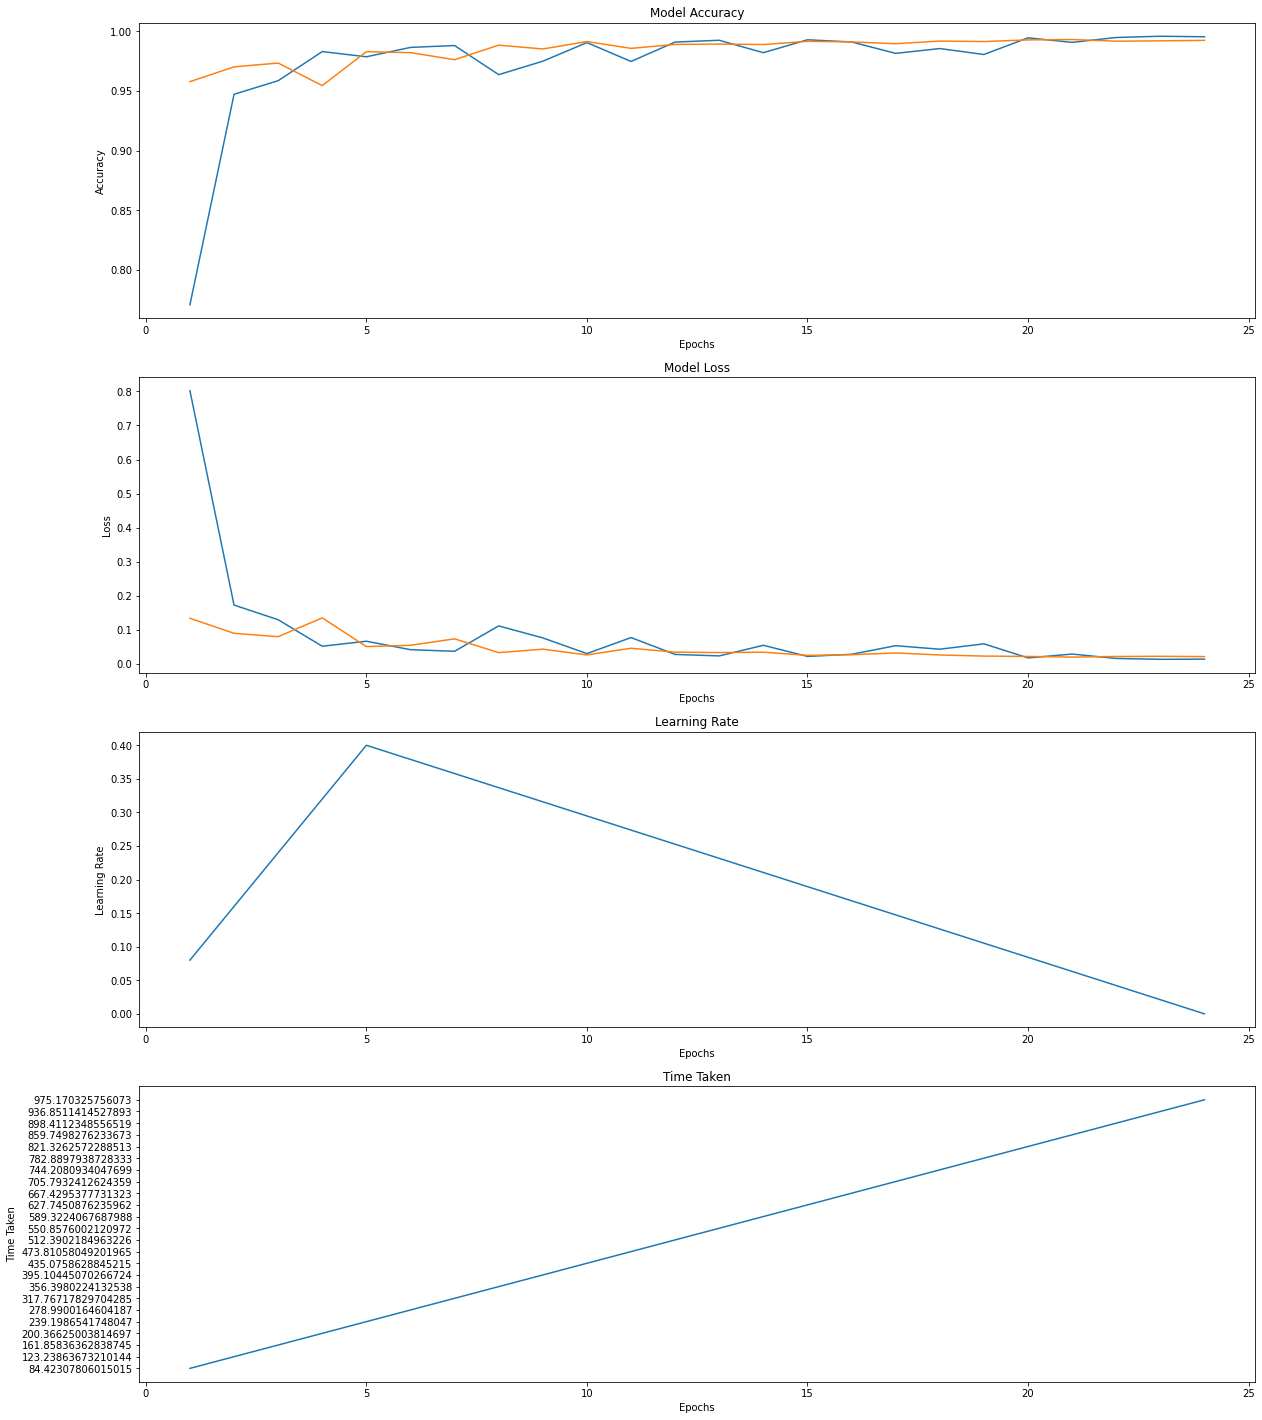

In [17]:
plt.figure (figsize=(20,25))
plt.subplot (411)
plt.title ('Model Accuracy')
plt.xlabel ('Epochs')
plt.ylabel ('Accuracy')
plt.plot (train_graph['epochs'], train_graph['train_acc'], train_graph['epochs'], train_graph['val_acc'])

plt.subplot (412)
plt.title ('Model Loss')
plt.xlabel ('Epochs')
plt.ylabel ('Loss')
plt.plot (train_graph['epochs'], train_graph['train_loss'], train_graph['epochs'], train_graph['val_loss'])

plt.subplot (413)
plt.title ('Learning Rate')
plt.xlabel ('Epochs')
plt.ylabel ('Learning Rate')
plt.plot (train_graph['epochs'], train_graph['learning_rate'])

plt.subplot (414)
plt.title ('Time Taken')
plt.xlabel ('Epochs')
plt.ylabel ('Time Taken')
plt.plot (train_graph['epochs'], train_graph['time_taken'])

plt.show ()

In [18]:
model.summary ()

Model: "david_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn (ConvBN)            multiple                  1984      
                                                                 
 res_blk (ResBlk)            multiple                  370176    
                                                                 
 res_blk_1 (ResBlk)          multiple                  295936    
                                                                 
 res_blk_2 (ResBlk)          multiple                  5904384   
                                                                 
 global_max_pooling2d (Globa  multiple                 0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               multiple                  5120      
                                                         

In [26]:
index = 1033
X = X_train[index]
x = x_train[index]

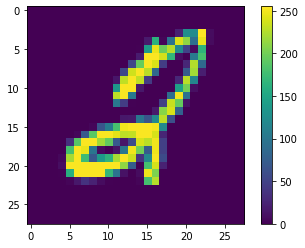

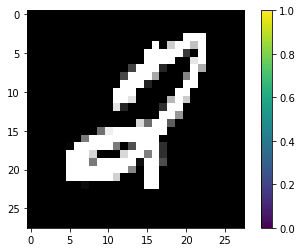

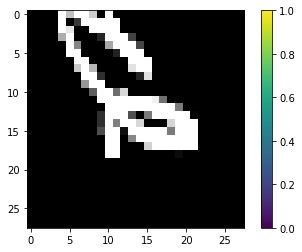

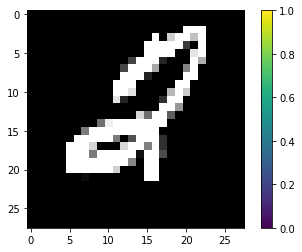

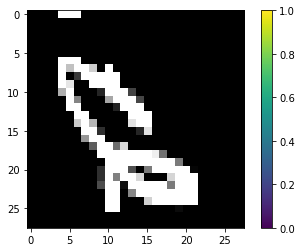

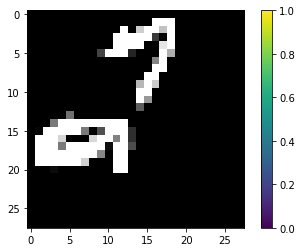

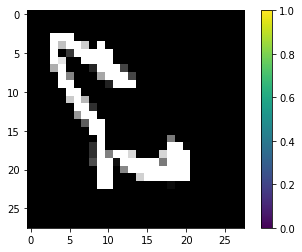

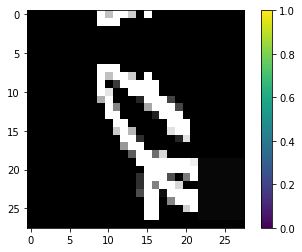

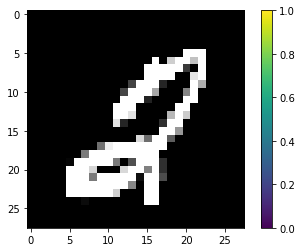

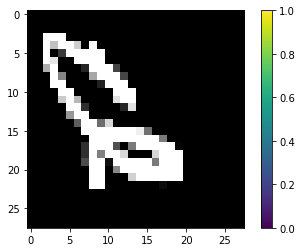

In [27]:
for i in range (10):
  plt.figure()
  if i == 0:
    plt.imshow(X)
  elif i == 1:
    plt.imshow(x[4:32, 4:32, ])
  else:
    plt.imshow(data_aug(x, 1)[0])
  plt.colorbar()
  plt.grid(False)
  plt.show()